In [3]:
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [34]:
df = pd.read_csv('./Dataset/train2,5k.csv')
df.head()

,class_index,review_text
0,4,well-done film
1,1,characters ramble
2,3,the intensity that made her an interesting cha...
3,1,'s not really funny
4,2,stuffs


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  2500 non-null   int64 
 1   review_text  2500 non-null   object
dtypes: int64(1), object(1)
memory usage: 39.2+ KB


Text(0.5, 1.0, 'Rating Distribution Across Dataset')

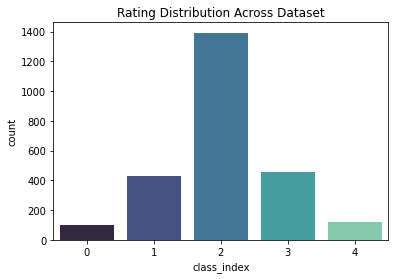

In [6]:
sns.countplot(data=df, x='class_index', palette='mako').set_title('Rating Distribution Across Dataset')

In [7]:
# Length of word in sentence
df['length'] = df['review_text'].apply(len)
df.head()

,class_index,review_text,length
0,4,well-done film,14
1,1,characters ramble,17
2,3,the intensity that made her an interesting cha...,66
3,1,'s not really funny,19
4,2,stuffs,6


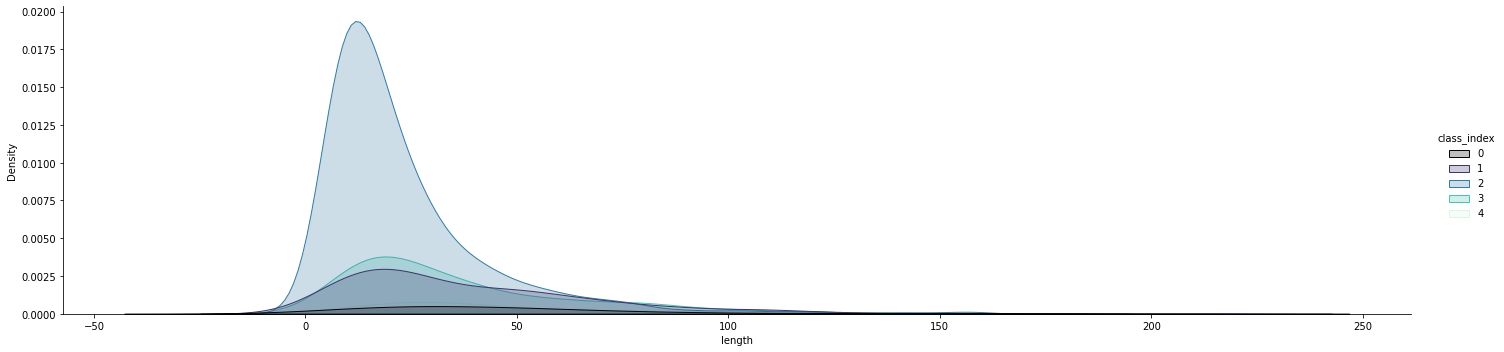

In [8]:
sns.displot(data=df, x='length', hue='class_index', palette='mako', kind='kde', fill=True, aspect=4)

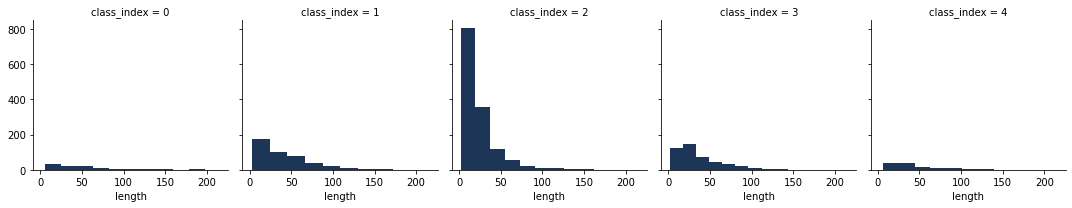

In [9]:
g = sns.FacetGrid(data=df, col='class_index')
g.map(plt.hist, 'length', color='#1D3557')

<AxesSubplot:xlabel='class_index', ylabel='length'>

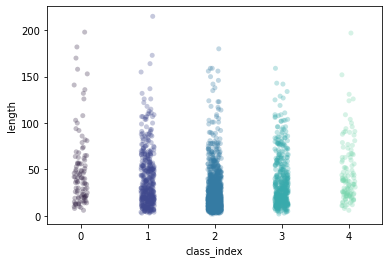

In [10]:
sns.stripplot(data=df, x='class_index', y='length', palette='mako', alpha=0.3)

Dari plot di atas kita dapat mengatakan bahwa semakin tinggi peringkat hotel, semakin besar kemungkinan pengunjung menulis ulasan yang panjang

In [39]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 2:
        return 'Good'
    elif score == 2:
        return 'Netral'
    else:
        return 'Bad'

In [40]:
df['class_index'] = df['class_index'].apply(rating)

In [13]:
df.head()

,class_index,review_text,length
0,Good,well-done film,14
1,Bad,characters ramble,17
2,Good,the intensity that made her an interesting cha...,66
3,Bad,'s not really funny,19
4,Netral,stuffs,6


In [14]:
# Total word in dataset before cleaning
length = df['length'].sum()

In [36]:
print('Original:')
print(df['review_text'][2])
print()

sentence = []
for word in df['review_text'][2].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['review_text'][2].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
the intensity that made her an interesting character to begin with

Stemming:
the intens that made her an interest charact to begin with

Lemmatization:
the intensity that make her an interest character to begin with


In [37]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    # #Stemming
    # sentence = []
    # for word in clean_text:
    #     stemmer = SnowballStemmer('english')
    #     sentence.append(stemmer.stem(word))

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [38]:
df['review_text'] = df['review_text'].apply(cleaning)

In [18]:
df['length'] = df['review_text'].apply(len)
new_length = df['length'].sum()

print('Total word before cleaning: {}'.format(length))
print('Total word after cleaning: {}'.format(new_length))

Total word before cleaning: 77205
Total word after cleaning: 53558


In [31]:
df['review_text']

0                                 welldone film
1                              character ramble
2       intensity make interest character begin
3                                  really funny
4                                         stuff
                         ...                   
2495                                        out
2496                                 classy 60s
2497                           fall fast asleep
2498                                   oedekerk
2499                  suitcase full easy answer
Name: review_text, Length: 2500, dtype: object

In [19]:
# # After cleaning, let's see the most common used word
# plt.figure(figsize=(20,20))
# wc = WordCloud(max_words=1000, min_font_size=10, 
#                 height=800,width=1600,background_color="white").generate(' '.join(df['review_text']))

# plt.imshow(wc)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df['review_text'], df['class_index'], test_size=0.3, random_state=0)

In [42]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [43]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

In [44]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

In [45]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,DecisionTreeClassifier,0.584000
1,RandomForestClassifier,0.594857
2,SVC,0.576000
3,LogisticRegression,0.585143
4,KNeighborsClassifier,0.562286
5,BernoulliNB,0.578857


In [46]:
log = RandomForestClassifier()
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

In [47]:
print(confusion_matrix(y_test, pred))

[[ 33  13 115]
 [  7  41 129]
 [ 12  20 380]]


In [48]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         Bad       0.63      0.20      0.31       161
        Good       0.55      0.23      0.33       177
      Netral       0.61      0.92      0.73       412

    accuracy                           0.61       750
   macro avg       0.60      0.45      0.46       750
weighted avg       0.60      0.61      0.55       750



In [28]:
# Random Forest Classifier
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfid.transform([clean_text])
    pred = log.predict(tfid_matrix)[0]
    
    return pred

In [30]:
text = "Such a comfy place to stay with the loved one"

print('Prediction using Random Forest Classifier: {}'.format(ml_predict(text)))

Prediction using Random Forest Classifier: Netral
